# MetaSeal Demo

This notebook demonstrates an end-to-end MetaSeal flow:
1. Generate a caption from an image.
2. Sign the caption with ECDSA.
3. Encode caption + signature into a QR payload.
4. Run MetaSeal inference.
5. Decode and verify the recovered signature.


## Prerequisites

Before running the notebook, make sure the following are available:
- Input image at `./data/image/cover_0.png`
- Key files: `private_key.pem` and `public_key.pem`
- Model/runtime dependencies (Transformers, Torch, Cryptography, qrcode, pyzbar, etc.)
- MetaSeal project paths configured as expected under `./scripts/` and output image paths under `./images/`


## Step 1: Generate Image Caption

This cell loads the cover image and uses an image-captioning model to produce text that will be signed.


In [2]:
from transformers import pipeline
import torch
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image = Image.open('./data/image/cover_0.png')

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=device)
image_to_text.model.config.max_new_tokens = 20 
output = image_to_text(image)  # Adjust max_length as needed
caption = output[0]['generated_text']
print(caption)


/home/tozhou/.conda/envs/watermark/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/home/tozhou/.conda/envs/watermark/lib/python3.12/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-mask

a bird is perched on a rock 


## Step 2: Sign Caption with ECDSA

This cell loads the PEM keys, signs the generated caption, and prints the signature in hex format.


In [3]:
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes
from cryptography.exceptions import InvalidSignature
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import serialization

# # Step 1: Generate an ECDSA key pair
# private_key = ec.generate_private_key(ec.SECP256R1())  # SECP256R1 curve for a 256-bit signature
# public_key = private_key.public_key()

# Load the private key
with open("private_key.pem", "rb") as f:
    private_key = serialization.load_pem_private_key(
        f.read(),
        password=None,
    )
    
with open("public_key.pem", "rb") as f:
    public_key = serialization.load_pem_public_key(f.read())

# Step 2: Sign the caption
caption_bytes = caption.encode('utf-8')  # Convert caption to bytes

# Sign using ECDSA
signature = private_key.sign(
    caption_bytes,
    ec.ECDSA(hashes.SHA256())
)
print("Caption:", caption)
print("Signature:", signature.hex())  # Signature in hexadecimal format

Caption: a bird is perched on a rock 
Signature: 304502206cd56cfdaefbb3232b512b789ccfc002eaaeecc04807f7dd91923cd9b28363c4022100ba2a61398050de13a797c91f3657613225b5529c52eb97c6f67281bf2003a612


## Step 3: Build JSON Payload

The caption and signature are serialized into a compact JSON payload for QR encoding.


In [4]:
import json


# Combine into a JSON object
combined_data = json.dumps({"caption": str(caption), "signature": str(signature.hex())})

# Print or use combined_data
print(combined_data)


{"caption": "a bird is perched on a rock ", "signature": "304502206cd56cfdaefbb3232b512b789ccfc002eaaeecc04807f7dd91923cd9b28363c4022100ba2a61398050de13a797c91f3657613225b5529c52eb97c6f67281bf2003a612"}


## Step 4: Create Secret QR Image

This cell converts the JSON payload into a QR image and resizes it to `512x512` for embedding or downstream processing.


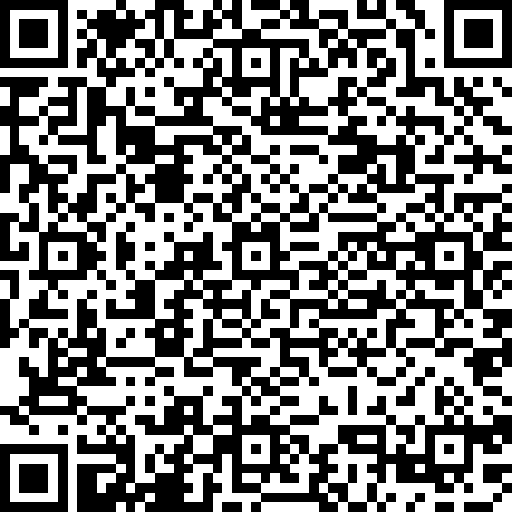

In [5]:
import qrcode


# Convert the signature to a QR code
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,  # This will be adjusted to achieve the desired size
    border=0,
)
qr.add_data(combined_data)
qr.make(fit=True)

# Create an image from the QR Code instance
img = qr.make_image(fill_color="black", back_color="white")


# Resize the image to 512x512 pixels
secret = img.resize((512,512))

# Save the image
secret.show()
# secret.save('dataset/secret_1.png')

## Step 5: Run MetaSeal Inference

Run the model pipeline to recover the hidden secret and report quality metrics (PSNR/SSIM).


In [6]:
import sys
sys.path.append('./scripts/')
from scripts.test_ori import inference
import scripts.config as c
from scripts.dataset import get_data_loaders
import matplotlib.pyplot as plt

# transformations = ['none','noise', 'brightness', 'contrast', 'blur', 'flip']
transformations = ['none']
for transformation in transformations:
    testloader = get_data_loaders(c, 2, c.cropsize_val, "val")
    psnr_s, psnr_c, ssim_c = inference(testloader, c, transformation)
    print(psnr_s, psnr_c, ssim_c)


cnt:  1
total:  1
success rate:  1.0
20.329952578766992 40.20062895761417 0.98083085


## Step 6: Decode and Verify Signature

Finally, decode the recovered QR payload, extract caption/signature, and verify authenticity with the public key.


In [7]:

from pyzbar.pyzbar import decode
from PIL import Image
import json

qr_image = Image.open("./images/secret-rev/secret_rev_0.png")
# qr_image = Image.open("/home/tozhou/project/MetaSeal/dataset/secret_1.png")
decoded_objects = decode(qr_image)
if decoded_objects:
    # decoded_signature_hex = decoded_objects[0].data.decode('utf-8')  # Decode from byte string to hex string
    # decoded_signature = bytes.fromhex(decoded_signature_hex)  # Convert back to bytes
    # print("Decoded Signature:", decoded_signature.hex())
    combined_data = decoded_objects[0].data

    # Split the combined data into caption and signature
    # decoded_caption_bytes, decoded_signature = combined_data.split(b'\x00', 1)
    # decoded_caption = decoded_caption_bytes.decode('utf-8')
    extracted_data = json.loads(combined_data)
    decoded_caption = extracted_data["caption"]
    decoded_signature = extracted_data["signature"]

    print("Decoded Caption:", decoded_caption)
    print("Decoded Signature:", decoded_signature)

    decoded_caption_bytes = decoded_caption.encode('utf-8')
    decoded_signature = bytes.fromhex(decoded_signature)
    try:
        public_key.verify(
            decoded_signature,
            decoded_caption_bytes,
            ec.ECDSA(hashes.SHA256())
        )
        print("Signature is valid.")
    except InvalidSignature:
        print("Signature is invalid.") 
else:
    print("No QR code found in the image.")

 

Decoded Caption: a living room with a fireplace and a table 
Decoded Signature: 304502205b2072441f8183d044ed5f3c370ffc5fc293bfbefae172ef37bebb0d226b2dea022100b2205729b74069eb66c5bf9e901ae55c14bfdfa397cfcee6b462bdd260281b42
Signature is valid.


## Expected Result

A successful run should print `Signature is valid.` in the final cell.
